# ARMA Task

In this part, we are supposed to do finish these tasks:
1. Preprocess data
2. Familar with data and define the kinds of sensor
3. Learn an autoregressive moving average model for each individual sensor
4. Use autocorrelation plots in order to identify the order of the ARMA models
5. Apply model selection methods to determine parameters

**Step1: Preprocessing**

In [136]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pandas.plotting import autocorrelation_plot
from datetime import datetime
from matplotlib.pylab import rcParams
from pandas.core import datetools
rcParams['figure.figsize'] = 15, 7
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy import  stats
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.api import qqplot
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
import scipy as sp
import scipy.stats

In [288]:
# ##################################################
# #               LOAD DATA                        #
# ##################################################
# train03 = pd.read_csv('BATADAL_dataset03.csv')
# train04 = pd.read_csv('BATADAL_dataset04.csv')
# test_set = pd.read_csv('BATADAL_test_dataset.csv')
# # shape of these three dataset
# # (8761, 45)# (4177, 45)# (2089, 44)
print(list(test_set))
L_group = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7']
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%y %H')

train04_series = pd.read_csv('BATADAL_dataset04_label.csv', sep='\s*,\s*',parse_dates=['DATETIME'], index_col='DATETIME', squeeze=True,date_parser=dateparse,engine='python')
X_train04 = train04_series.fillna(train04_series.bfill())
X_train04 = X_train04.drop('ATT_FLAG',axis=1,inplace=False)
y_train04 = train04_series['ATT_FLAG']

train03_series = pd.read_csv('BATADAL_dataset03.csv', sep='\s*,\s*',parse_dates=['DATETIME'], index_col='DATETIME', squeeze=True,date_parser=dateparse,engine='python')
X_train03 = train03_series.drop('ATT_FLAG',axis=1,inplace=False)
y_train03 = train03_series['ATT_FLAG']

temp_test = pd.read_csv('BATADAL_test_dataset_label.csv', sep='\s*,\s*',parse_dates=['DATETIME'], index_col='DATETIME', squeeze=True,date_parser=dateparse,engine='python')
test_set = temp_test.drop('AUU_FLAG',axis=1,inplace=False)
y_test= temp_test['AUU_FLAG']
print(X_train04.index)

['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7', 'F_PU1', 'S_PU1', 'F_PU2', 'S_PU2', 'F_PU3', 'S_PU3', 'F_PU4', 'S_PU4', 'F_PU5', 'S_PU5', 'F_PU6', 'S_PU6', 'F_PU7', 'S_PU7', 'F_PU8', 'S_PU8', 'F_PU9', 'S_PU9', 'F_PU10', 'S_PU10', 'F_PU11', 'S_PU11', 'F_V2', 'S_V2', 'P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J415', 'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']
DatetimeIndex(['2016-07-04 00:00:00', '2016-07-04 01:00:00',
               '2016-07-04 02:00:00', '2016-07-04 03:00:00',
               '2016-07-04 04:00:00', '2016-07-04 05:00:00',
               '2016-07-04 06:00:00', '2016-07-04 07:00:00',
               '2016-07-04 08:00:00', '2016-07-04 09:00:00',
               ...
               '2016-12-24 15:00:00', '2016-12-24 16:00:00',
               '2016-12-24 17:00:00', '2016-12-24 18:00:00',
               '2016-12-24 19:00:00', '2016-12-24 20:00:00',
               '2016-12-24 21:00:00', '2016-12-24 22:00:00',
               '2016-12-24 23:00:00', 

 For simplicity, we can use the fillna() function to ensure that we have no missing values in our time series

- Apply timestamp as index
- Rescale to obtain zero mean and unit variance


**Step 2: Familirization**

Familar with data and define the kinds of sensor. L_group = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T5', 'L_T6', 'L_T7'] is our sensor group including 7 different sensors.

In [120]:
def stationarity_test(dataset,column_name,number):
    data = dataset.copy()
    data = data.iloc[: len(data)-number] #exclude last 'number' of data
    #stationary test
    from statsmodels.tsa.stattools import adfuller as ADF
    diff = 0
    adf = ADF(data[column_name])
    while adf[1] > 0.05:
        diff = diff + 1
        adf = ADF(data[column_name].diff(diff).dropna())
    print(u'After %s diff, the series is stationary，p value is%s' %(diff, adf[1]))
def whitenoise_test(dataset,column_name,number):
    data = dataset.copy()
    data = data.iloc[: len(data)-number] 
    from statsmodels.stats.diagnostic import acorr_ljungbox
    [[lb], [p]] = acorr_ljungbox(data[column_name], lags = 1)
    if p < 0.05:
        print(u'the original series is non-white noise series，p value is：%s' %p)
    else:
        print(u'the original series is white noise series，p value is：%s' %p)
    [[lb], [p]] = acorr_ljungbox(data[column_name].diff().dropna(), lags = 1)
    if p < 0.05:
        print(u'First-order differential series is non-white noise series，p value is：%s' %p)
    else:
        print(u'First-order differential series is white noise series，p value is：%s' %p)

**Step 2.1:** is stationary or not? which is the optimal differential coefficient? is it white-noise series?

In [5]:
X_train03_preprocessed = pd.DataFrame()
for column_name in L_group: 
    print('for sensor:',column_name)
    stationarity_test(X_train03,column_name, 30 )
    whitenoise_test(X_train03,column_name, 30 )
    print('----------------------------------')
#     X_train03_preprocessed[column_name] = X_train03[column_name].diff(1)
#     X_train03_preprocessed[column_name].plot()
#     plt.show()

for sensor: L_T1
After 0 diff, the series is stationary，p value is0.0
the original series is non-white noise series，p value is：0.0
First-order differential series is non-white noise series，p value is：0.0
----------------------------------
for sensor: L_T2
After 0 diff, the series is stationary，p value is2.0664924042521113e-30
the original series is non-white noise series，p value is：0.0
First-order differential series is non-white noise series，p value is：0.0
----------------------------------
for sensor: L_T3
After 0 diff, the series is stationary，p value is9.673433370567284e-27
the original series is non-white noise series，p value is：0.0
First-order differential series is non-white noise series，p value is：0.0
----------------------------------
for sensor: L_T4
After 0 diff, the series is stationary，p value is1.9682468722464932e-29
the original series is non-white noise series，p value is：0.0
First-order differential series is non-white noise series，p value is：7.081643858731659e-13
-----

All column in series are stationary and non-white noise series from the results. 

**Step 2.2** Find possible parameters by partial autocorrelation plot and autocorrelation plot

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.
*We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

For Sensor: L_T1


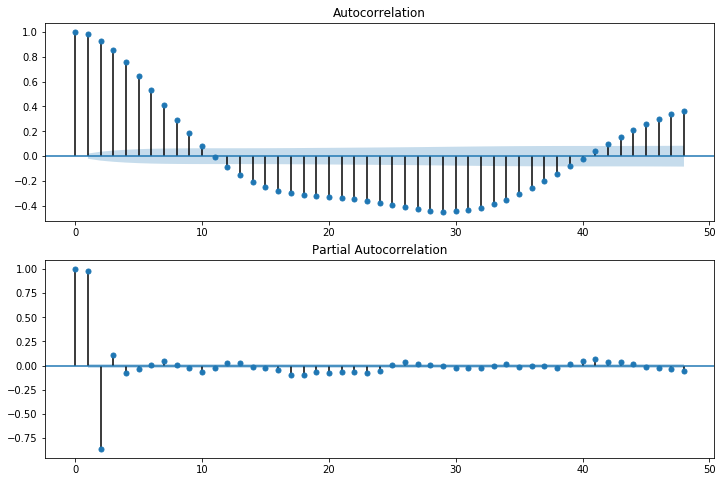

---------------------------
For Sensor: L_T2


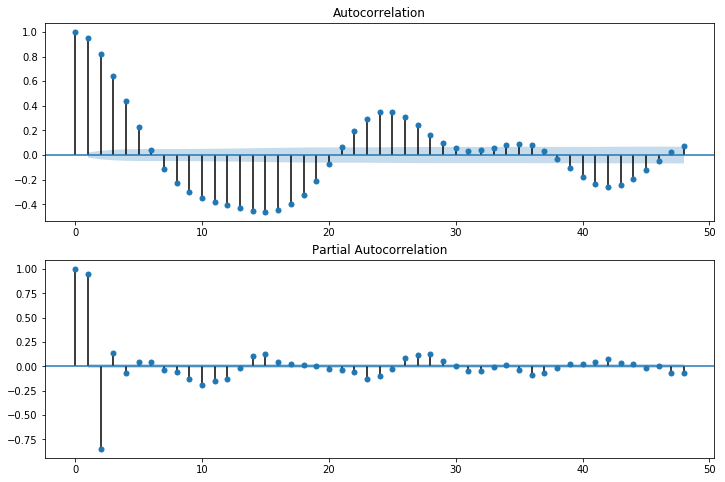

---------------------------
For Sensor: L_T3


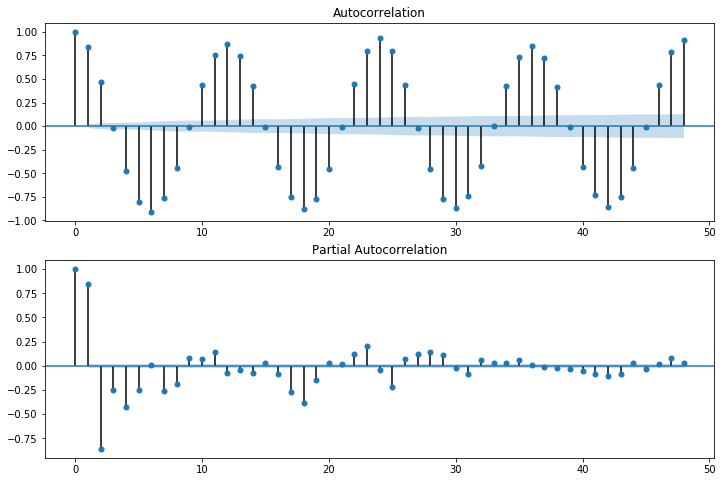

---------------------------
For Sensor: L_T4


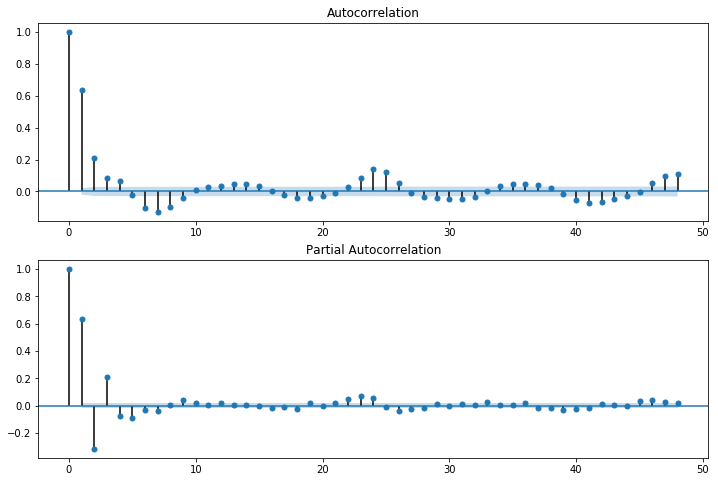

---------------------------
For Sensor: L_T5


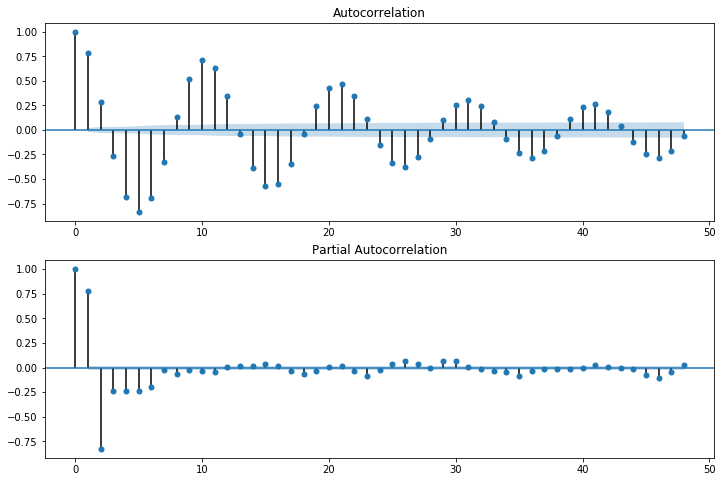

---------------------------
For Sensor: L_T6


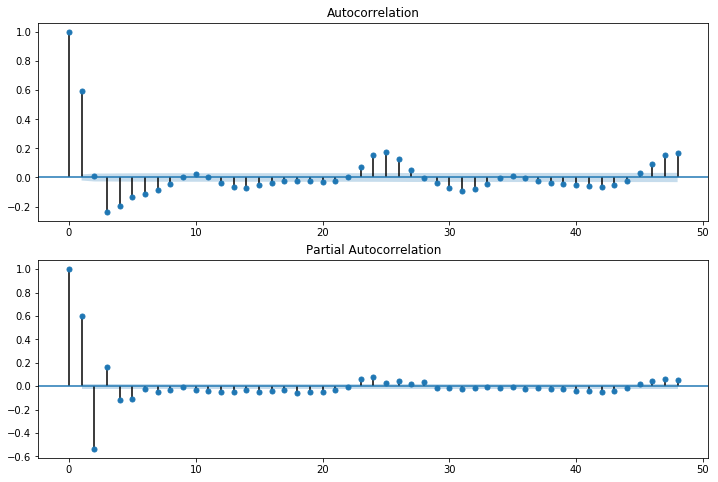

---------------------------
For Sensor: L_T7


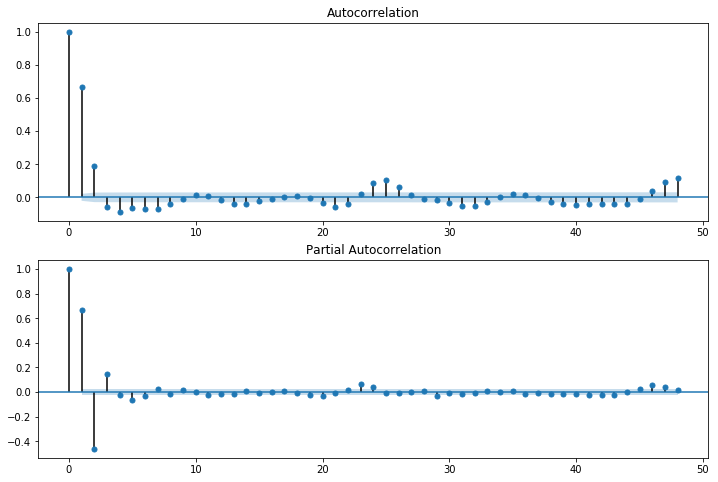

---------------------------


In [122]:
for column_name in L_group: 
    print('For Sensor:', column_name)
    dta= X_train03[column_name]
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(dta.values.squeeze(), lags=48, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(dta, lags=48, ax=ax2)
    plt.show()
    print('---------------------------')

--------------------------------------------------------------------------------------------------------------------------
#Step 2.4 Find the optimal parameters by AIC

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

For each sensor:

In [13]:
arma_models = []
p_values = range(1,6)
d_values = range(0,3)
q_values = range(0,3)
Best_models = {}
for sensor in L_group:
        dataset_test = X_train03[sensor]
        Ps = []
        Ds = []
        Qs = []
        resids = []
        dws = []
        AICs = []
        print("sensor:", sensor)
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    try:
                        model = sm.tsa.ARIMA(dataset_test, order=(p,d,q))
                        model_fit = model.fit()
                        print("p : %d, d: %d, q: %d, AIC: %.2f"%(p,d,q,model_fit.aic))
                        Ps.append(p)
                        Ds.append(d)
                        Qs.append(q)
                        AICs.append(model_fit.aic)
                        #obey the theory or not
                        dws.append(sm.stats.durbin_watson(model_fit.resid.values))
                        resids.append(model_fit.resid)

                    except:
                        pass
        idx = np.argmin(AICs)
        Best_models[sensor] = [Ps[idx],Ds[idx],Qs[idx],AICs[idx],resids[idx],dws[idx]]
print(Best_models)
#LT1 -- 5,0,1
#LT2 -- 5,0,2
#LT3 -- 5,0,2
#LT4 -- 5,0,2
#LT5 -- 5,0,2
#LT6 -- 5,0,2
#LT7 -- 4,0,2

sensor: L_T1
p : 1, d: 0, q: 0, AIC: -558.10


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


p : 1, d: 0, q: 1, AIC: -7752.46
p : 1, d: 0, q: 2, AIC: -10576.71
p : 1, d: 1, q: 0, AIC: -11899.70
p : 1, d: 1, q: 1, AIC: -12444.85
p : 1, d: 1, q: 2, AIC: -12460.70
p : 1, d: 2, q: 0, AIC: -11461.06
p : 1, d: 2, q: 1, AIC: -11528.49


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 1, d: 2, q: 2, AIC: -12433.04
p : 2, d: 0, q: 0, AIC: -13038.32
p : 2, d: 0, q: 1, AIC: -13266.34
p : 2, d: 0, q: 2, AIC: -13286.69
p : 2, d: 1, q: 0, AIC: -12472.27
p : 2, d: 1, q: 1, AIC: -13031.91


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 1, q: 2, AIC: -13259.87
p : 2, d: 2, q: 0, AIC: -11566.76


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 2, q: 1, AIC: -12459.43


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 2, q: 2, AIC: -12456.21
p : 3, d: 0, q: 0, AIC: -13229.09
p : 3, d: 0, q: 1, AIC: -13277.97
p : 3, d: 0, q: 2, AIC: -13412.40
p : 3, d: 1, q: 0, AIC: -12470.30


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 1, AIC: -13218.59


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 2, AIC: -13271.66
p : 3, d: 2, q: 0, AIC: -11577.01


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 2, q: 1, AIC: -12459.01


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 2, q: 2, AIC: -12460.06
p : 4, d: 0, q: 0, AIC: -13302.66


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 0, q: 1, AIC: -13386.81


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 0, q: 2, AIC: -13411.09
p : 4, d: 1, q: 0, AIC: -12508.11


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 1, q: 1, AIC: -13296.30
p : 4, d: 1, q: 2, AIC: -13290.58
p : 4, d: 2, q: 0, AIC: -11577.26


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 2, q: 1, AIC: -12494.96


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 2, q: 2, AIC: -12789.21
p : 5, d: 0, q: 0, AIC: -13306.71


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 0, q: 1, AIC: -13413.79
p : 5, d: 0, q: 2, AIC: -13402.25
p : 5, d: 1, q: 0, AIC: -12584.66


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 1, AIC: -13280.32


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 2, AIC: -13272.66
p : 5, d: 2, q: 0, AIC: -11575.27


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 2, q: 1, AIC: -12554.61


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


sensor: L_T2
p : 1, d: 0, q: 0, AIC: 11081.94
p : 1, d: 0, q: 1, AIC: 4485.76
p : 1, d: 0, q: 2, AIC: 1977.72
p : 1, d: 1, q: 0, AIC: 2267.85
p : 1, d: 1, q: 1, AIC: 1433.38
p : 1, d: 1, q: 2, AIC: 1349.47
p : 1, d: 2, q: 0, AIC: 2809.87
p : 1, d: 2, q: 1, AIC: 2276.44
p : 2, d: 0, q: 0, AIC: -15.64
p : 2, d: 0, q: 1, AIC: -206.84
p : 2, d: 0, q: 2, AIC: -221.14
p : 2, d: 1, q: 0, AIC: 1222.61
p : 2, d: 1, q: 1, AIC: -6.04


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 1, q: 2, AIC: -195.72
p : 2, d: 2, q: 0, AIC: 2741.95
p : 2, d: 2, q: 2, AIC: 144.30
p : 3, d: 0, q: 0, AIC: -180.44
p : 3, d: 0, q: 1, AIC: -218.82
p : 3, d: 0, q: 2, AIC: -316.31
p : 3, d: 1, q: 0, AIC: 1150.05


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 1, AIC: -173.44


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:628: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:628: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:629: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:629: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 2, AIC: -199.25
p : 3, d: 2, q: 0, AIC: 2741.95


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 2, q: 2, AIC: -53.76
p : 4, d: 0, q: 0, AIC: -216.97
p : 4, d: 0, q: 1, AIC: -306.65
p : 4, d: 0, q: 2, AIC: -314.34
p : 4, d: 1, q: 0, AIC: 858.77


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 1, q: 1, AIC: -201.72
p : 4, d: 1, q: 2, AIC: -94.73
p : 4, d: 2, q: 0, AIC: 2706.44


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 2, q: 2, AIC: 615.09
p : 5, d: 0, q: 0, AIC: -230.95
p : 5, d: 0, q: 1, AIC: -307.64
p : 5, d: 0, q: 2, AIC: -585.66
p : 5, d: 1, q: 0, AIC: 635.95


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 1, AIC: -223.63


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 2, AIC: -101.83
p : 5, d: 2, q: 0, AIC: 2488.17
p : 5, d: 2, q: 2, AIC: 617.64
sensor: L_T3
p : 1, d: 0, q: 0, AIC: 7180.81
p : 1, d: 0, q: 1, AIC: 1561.88
p : 1, d: 0, q: 2, AIC: -845.22
p : 1, d: 1, q: 0, AIC: 1656.18
p : 1, d: 1, q: 1, AIC: 7188.35
p : 1, d: 2, q: 0, AIC: 2692.09
p : 2, d: 0, q: 0, AIC: -4550.17
p : 2, d: 0, q: 1, AIC: -6946.85
p : 2, d: 0, q: 2, AIC: -7338.44
p : 2, d: 1, q: 0, AIC: 238.06
p : 2, d: 2, q: 0, AIC: 2645.15
p : 3, d: 0, q: 0, AIC: -5094.42
p : 3, d: 0, q: 1, AIC: -7172.93
p : 3, d: 0, q: 2, AIC: -7394.31
p : 3, d: 1, q: 0, AIC: -214.99
p : 3, d: 2, q: 0, AIC: 2643.91
p : 4, d: 0, q: 0, AIC: -6837.64
p : 4, d: 0, q: 1, AIC: -7590.83
p : 4, d: 0, q: 2, AIC: -7593.42
p : 4, d: 1, q: 0, AIC: -1854.64


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 1, q: 2, AIC: -7489.52
p : 4, d: 2, q: 0, AIC: 2523.66
p : 5, d: 0, q: 0, AIC: -7399.46
p : 5, d: 0, q: 1, AIC: -7620.45
p : 5, d: 0, q: 2, AIC: -7710.38
p : 5, d: 1, q: 0, AIC: -4091.21


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 2, AIC: -7380.73
p : 5, d: 2, q: 0, AIC: 368.82
sensor: L_T4
p : 1, d: 0, q: 0, AIC: 9551.25
p : 1, d: 0, q: 1, AIC: 8307.28
p : 1, d: 0, q: 2, AIC: 8234.73
p : 1, d: 1, q: 0, AIC: 11266.03
p : 1, d: 1, q: 1, AIC: 9560.18
p : 1, d: 1, q: 2, AIC: 8316.55
p : 1, d: 2, q: 0, AIC: 16175.23
p : 2, d: 0, q: 0, AIC: 8622.05
p : 2, d: 0, q: 1, AIC: 8283.15
p : 2, d: 0, q: 2, AIC: 8229.37
p : 2, d: 1, q: 0, AIC: 9623.14


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 1, q: 1, AIC: 8632.79
p : 2, d: 1, q: 2, AIC: 8294.18
p : 2, d: 2, q: 0, AIC: 13799.27
p : 3, d: 0, q: 0, AIC: 8241.10
p : 3, d: 0, q: 1, AIC: 8217.24
p : 3, d: 0, q: 2, AIC: 8180.32
p : 3, d: 1, q: 0, AIC: 9564.68


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 1, AIC: 8250.24


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 2, AIC: 8237.14
p : 3, d: 2, q: 0, AIC: 12707.96
p : 4, d: 0, q: 0, AIC: 8194.68
p : 4, d: 0, q: 1, AIC: 8126.12
p : 4, d: 0, q: 2, AIC: 8104.89
p : 4, d: 1, q: 0, AIC: 9527.72


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 1, q: 1, AIC: 8204.92


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 1, q: 2, AIC: 8162.73
p : 4, d: 2, q: 0, AIC: 12270.68
p : 5, d: 0, q: 0, AIC: 8122.55
p : 5, d: 0, q: 1, AIC: 8108.63


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 0, q: 2, AIC: 7958.93
p : 5, d: 1, q: 0, AIC: 9402.65


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 1, AIC: 8137.34
p : 5, d: 1, q: 2, AIC: 8158.48
p : 5, d: 2, q: 0, AIC: 11889.57
sensor: L_T5
p : 1, d: 0, q: 0, AIC: 11252.56
p : 1, d: 0, q: 1, AIC: 6505.37
p : 1, d: 0, q: 2, AIC: 4874.61
p : 1, d: 1, q: 0, AIC: 7932.25
p : 1, d: 1, q: 1, AIC: 7068.61
p : 1, d: 2, q: 0, AIC: 9534.14
p : 2, d: 0, q: 0, AIC: 1236.81
p : 2, d: 0, q: 1, AIC: -211.26
p : 2, d: 0, q: 2, AIC: -548.06
p : 2, d: 1, q: 0, AIC: 6209.10
p : 2, d: 2, q: 0, AIC: 9474.20
p : 3, d: 0, q: 0, AIC: 718.91
p : 3, d: 0, q: 1, AIC: -494.19
p : 3, d: 0, q: 2, AIC: -546.90
p : 3, d: 1, q: 0, AIC: 5138.42
p : 3, d: 2, q: 0, AIC: 9077.56
p : 4, d: 0, q: 0, AIC: 215.95
p : 4, d: 0, q: 1, AIC: -588.62
p : 4, d: 0, q: 2, AIC: -637.88
p : 4, d: 1, q: 0, AIC: 4343.42
p : 4, d: 2, q: 0, AIC: 8524.26
p : 5, d: 0, q: 0, AIC: -289.07
p : 5, d: 0, q: 1, AIC: -654.86
p : 5, d: 0, q: 2, AIC: -658.37
p : 5, d: 1, q: 0, AIC: 3565.96
p : 5, d: 2, q: 0, AIC: 8071.42
sensor: L_T6
p : 1, d: 0, q: 0, AIC: -9261.88
p : 1, d: 0, 

C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 1, d: 1, q: 1, AIC: -9250.67
p : 1, d: 2, q: 0, AIC: -3492.72
p : 2, d: 0, q: 0, AIC: -12212.72
p : 2, d: 0, q: 1, AIC: -12499.92
p : 2, d: 0, q: 2, AIC: -12509.16
p : 2, d: 1, q: 0, AIC: -10239.70
p : 2, d: 1, q: 1, AIC: -12198.42
p : 2, d: 1, q: 2, AIC: -12482.41
p : 2, d: 2, q: 0, AIC: -5734.19
p : 3, d: 0, q: 0, AIC: -12450.75
p : 3, d: 0, q: 1, AIC: -12499.25
p : 3, d: 0, q: 2, AIC: -12702.56
p : 3, d: 1, q: 0, AIC: -10395.10
p : 3, d: 2, q: 0, AIC: -6762.63
p : 4, d: 0, q: 0, AIC: -12566.38
p : 4, d: 0, q: 1, AIC: -12762.37
p : 4, d: 0, q: 2, AIC: -12765.84
p : 4, d: 1, q: 0, AIC: -10555.05
p : 4, d: 2, q: 0, AIC: -7214.73
p : 5, d: 0, q: 0, AIC: -12667.02
p : 5, d: 0, q: 1, AIC: -12768.61
p : 5, d: 0, q: 2, AIC: -12773.41
p : 5, d: 1, q: 0, AIC: -10893.16


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 1, AIC: -12632.35
p : 5, d: 2, q: 0, AIC: -7777.63
sensor: L_T7
p : 1, d: 0, q: 0, AIC: 16381.31
p : 1, d: 0, q: 1, AIC: 14436.16
p : 1, d: 0, q: 2, AIC: 14155.03
p : 1, d: 1, q: 0, AIC: 17527.37
p : 1, d: 1, q: 1, AIC: 16893.33
p : 1, d: 2, q: 0, AIC: 21686.23
p : 2, d: 0, q: 0, AIC: 14280.37
p : 2, d: 0, q: 1, AIC: 14101.38
p : 2, d: 0, q: 2, AIC: 14076.03
p : 2, d: 1, q: 0, AIC: 15898.10
p : 2, d: 1, q: 1, AIC: 14283.77


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 2, d: 1, q: 2, AIC: 14105.57
p : 2, d: 2, q: 0, AIC: 20192.59
p : 3, d: 0, q: 0, AIC: 14089.01
p : 3, d: 0, q: 1, AIC: 14088.92
p : 3, d: 0, q: 2, AIC: 14076.70
p : 3, d: 1, q: 0, AIC: 15643.73


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 1, AIC: 14100.10


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 3, d: 1, q: 2, AIC: 14118.23
p : 3, d: 2, q: 0, AIC: 19103.00
p : 4, d: 0, q: 0, AIC: 14087.08
p : 4, d: 0, q: 1, AIC: 14061.35
p : 4, d: 0, q: 2, AIC: 14043.00
p : 4, d: 1, q: 0, AIC: 15545.79


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 1, q: 1, AIC: 14106.73


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 4, d: 1, q: 2, AIC: 14120.03
p : 4, d: 2, q: 0, AIC: 18548.15
p : 5, d: 0, q: 0, AIC: 14048.89
p : 5, d: 0, q: 1, AIC: 14044.67
p : 5, d: 0, q: 2, AIC: 14044.29
p : 5, d: 1, q: 0, AIC: 15400.58


C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


p : 5, d: 1, q: 1, AIC: 14053.30
p : 5, d: 1, q: 2, AIC: 14083.49
p : 5, d: 2, q: 0, AIC: 18232.59
{'L_T1': [5, 0, 1, -13413.792095647947, DATETIME
2014-01-06 00:00:00   -2.168450
2014-01-06 01:00:00   -0.138674
2014-01-06 02:00:00   -0.088993
2014-01-06 03:00:00    0.018382
2014-01-06 04:00:00    0.046504
2014-01-06 05:00:00    0.091768
2014-01-06 06:00:00    0.054756
2014-01-06 07:00:00   -0.157205
2014-01-06 08:00:00   -0.099089
2014-01-06 09:00:00   -0.094301
2014-01-06 10:00:00   -0.099769
2014-01-06 11:00:00   -0.111306
2014-01-06 12:00:00   -0.002069
2014-01-06 13:00:00   -0.040772
2014-01-06 14:00:00   -0.176898
2014-01-06 15:00:00    0.011188
2014-01-06 16:00:00    0.046235
2014-01-06 17:00:00   -0.088992
2014-01-06 18:00:00    0.019967
2014-01-06 19:00:00    0.000298
2014-01-06 20:00:00   -0.137324
2014-01-06 21:00:00    0.125828
2014-01-06 22:00:00   -0.077034
2014-01-06 23:00:00   -0.037319
2014-01-07 00:00:00    0.050741
2014-01-07 01:00:00    0.070038
2014-01-07 02:00:00 

In [46]:
L_T1= X_train03['L_T1']
arma_mod1 = sm.tsa.ARMA(L_T1,(5,0,1)).fit()
print(arma_mod1.aic,arma_mod1.bic,arma_mod1.hqic)
L_T2= X_train03['L_T2']
arma_mod2 = sm.tsa.ARMA(L_T2,(5,0,2)).fit()
print(arma_mod2.aic,arma_mod2.bic,arma_mod2.hqic)
L_T3= X_train03['L_T3']
arma_mod3 = sm.tsa.ARMA(L_T3,(5,0,2)).fit()
print(arma_mod3.aic,arma_mod3.bic,arma_mod3.hqic)
L_T4= X_train03['L_T4']
arma_mod4 = sm.tsa.ARMA(L_T4,(5,0,2)).fit()
print(arma_mod4.aic,arma_mod4.bic,arma_mod4.hqic)
L_T5= X_train03['L_T5']
arma_mod5 = sm.tsa.ARMA(L_T5,(5,0,2)).fit()
print(arma_mod5.aic,arma_mod5.bic,arma_mod5.hqic)
L_T6= X_train03['L_T6']
arma_mod6 = sm.tsa.ARMA(L_T6,(5,0,2)).fit()
print(arma_mod6.aic,arma_mod6.bic,arma_mod6.hqic)
L_T7= X_train03['L_T7']
arma_mod7 = sm.tsa.ARMA(L_T7,(4,0,2)).fit()
print(arma_mod7.aic,arma_mod7.bic,arma_mod7.hqic)

C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


-13306.70654694735 -13257.160089618685 -13289.824491535854
-230.95274033162787 -181.4062830029633 -214.07068492013175
-7399.461147462574 -7349.91469013391 -7382.579092051078
8122.548867016532 8172.095324345197 8139.430922428029
-289.0652707161753 -239.51881338751073 -272.18321530467915
-12667.023544529457 -12617.477087200792 -12650.141489117961
14087.078652701794 14129.547044697792 14101.548985911648


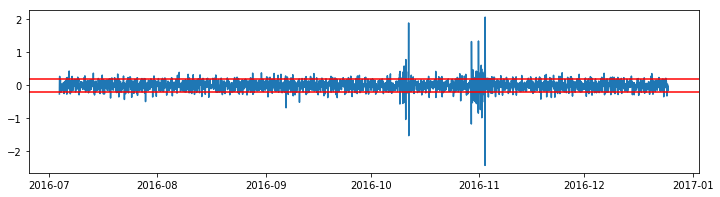

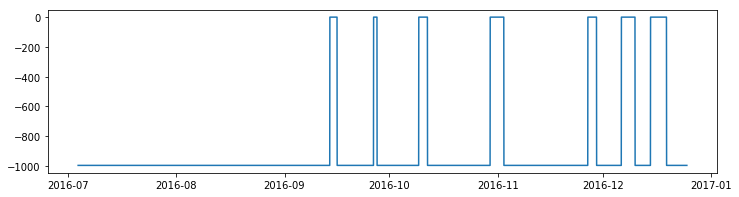

In [277]:
# calculate percentage of anomaly
# import datetime
# datetime.datetime(2017,4,1)-datetime.datetime(2017,1,4)
# 492
# 4176
#407
#2088
plt.figure(figsize=(12,3))
plt.plot(resid1)
plt.axhline(y=0.1898, color='r', linestyle='-')
plt.axhline(y=-0.1896, color='r', linestyle='-')
plt.show()
plt.figure(figsize=(12,3))
plt.plot(y_train04_series)
plt.show()

In [286]:
def find_threshold(data,percentage):
    lower = np.percentile(data, 100-percentage, axis=0)
    upper = np.percentile(data, percentage, axis=0)
    return lower,upper
# resid_threshold = 0.882
percentage = 94.1
# percentage = 99.8
arma_mod1 = sm.tsa.ARMA(train04_series['L_T1'],(5,0,1)).fit()
# print(sm.stats.durbin_watson(arma_mod1.resid.values))
resid1 = arma_mod1.resid
lower1,upper1 = find_threshold(resid1,percentage)
print('For sensor L_T1 the threshold should be:',lower1, upper1)
arma_mod2 = sm.tsa.ARMA(train04_series['L_T2'],(5,0,2)).fit()
# print(sm.stats.durbin_watson(arma_mod1.resid.values))
resid2 = arma_mod2.resid
lower2,upper2 = find_threshold(resid2,percentage)
print('For sensor L_T2 the threshold should be:',lower2, upper2)
arma_mod3 = sm.tsa.ARMA(train04_series['L_T3'],(5,0,2)).fit()
# print(sm.stats.durbin_watson(arma_mod1.resid.values))
resid3 = arma_mod3.resid
lower3,upper3 = find_threshold(resid3,percentage)
print('For sensor L_T3 the threshold should be:',lower3, upper3)
arma_mod4 = sm.tsa.ARMA(train04_series['L_T4'],(5,0,2)).fit()
# print(sm.stats.durbin_watson(arma_mod1.resid.values))
resid4 = arma_mod4.resid
lower4,upper4 = find_threshold(resid4,percentage)
print('For sensor L_T4 the threshold should be:',lower4,upper4)
arma_mod5 = sm.tsa.ARMA(train04_series['L_T5'],(5,0,2)).fit()
# print(sm.stats.durbin_watson(arma_mod1.resid.values))
resid5 = arma_mod5.resid
lower5,upper5 = find_threshold(resid5,percentage)
print('For sensor L_T5 the threshold should be:',lower5,upper5)
arma_mod6 = sm.tsa.ARMA(train04_series['L_T6'],(5,0,2)).fit()
# print(sm.stats.durbin_watson(arma_mod1.resid.values))
resid6 = arma_mod6.resid
lower6,upper6 = find_threshold(resid6,percentage)
print('For sensor L_T6 the threshold should be:',lower6,upper6)
arma_mod7 = sm.tsa.ARMA(train04_series['L_T7'],(4,0,2)).fit()
# print(sm.stats.durbin_watson(arma_mod1.resid.values))
resid7 = arma_mod7.resid
lower7,upper7 = find_threshold(resid7,percentage)
print('For sensor L_T7 the threshold should be:',lower7,upper7)
lower_threshold_train04_series= [lower1,lower2,lower3,lower4,lower5,lower6,lower7]
upper_threshold_train04_series= [upper1,upper2,upper3,upper4,upper5,upper6,upper7]
# plt.plot(resid1)
# plt.axhline(y=0.5,color = 'r')
# plt.axhline(y=-0.5,color = 'r')
# fig = plt.figure(figsize=(12,8))

C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


For sensor L_T1 the threshold should be: -0.18959138870954434 0.1897615920727185
For sensor L_T2 the threshold should be: -0.3337388488623592 0.39901103297351326
For sensor L_T3 the threshold should be: -0.29857331746234606 0.22536294981199478
For sensor L_T4 the threshold should be: -0.6546637309359921 0.5300676509034912
For sensor L_T5 the threshold should be: -0.33889513935903764 0.3923923134301428
For sensor L_T6 the threshold should be: -0.22324762903063128 0.12543316884579264
For sensor L_T7 the threshold should be: -0.8940771938106151 0.7686794485842594


In [278]:
arma_mod1 = sm.tsa.ARMA(test_set['L_T1'],(5,0,1)).fit()
# print(sm.stats.durbin_watson(arma_mod1.resid.values))
resid1 = arma_mod1.resid
lower1,upper1 = find_threshold(resid1,percentage)
print('For sensor L_T1 the threshold should be:',lower1, upper1)
arma_mod2 = sm.tsa.ARMA(test_set['L_T2'],(5,0,2)).fit()
# print(sm.stats.durbin_watson(arma_mod1.resid.values))
resid2 = arma_mod2.resid
lower2,upper2 = find_threshold(resid2,percentage)
print('For sensor L_T2 the threshold should be:',lower2, upper2)
arma_mod3 = sm.tsa.ARMA(test_set['L_T3'],(5,0,2)).fit()
# print(sm.stats.durbin_watson(arma_mod1.resid.values))
resid3 = arma_mod3.resid
lower3,upper3 = find_threshold(resid3,percentage)
print('For sensor L_T3 the threshold should be:',lower3, upper3)
arma_mod4 = sm.tsa.ARMA(test_set['L_T4'],(5,0,2)).fit()
# print(sm.stats.durbin_watson(arma_mod1.resid.values))
resid4 = arma_mod4.resid
lower4,upper4 = find_threshold(resid4,percentage)
print('For sensor L_T4 the threshold should be:',lower4,upper4)
arma_mod5 = sm.tsa.ARMA(test_set['L_T5'],(5,0,2)).fit()
# print(sm.stats.durbin_watson(arma_mod1.resid.values))
resid5 = arma_mod5.resid
lower5,upper5 = find_threshold(resid5,percentage)
print('For sensor L_T5 the threshold should be:',lower5,upper5)
arma_mod6 = sm.tsa.ARMA(test_set['L_T6'],(5,0,2)).fit()
# print(sm.stats.durbin_watson(arma_mod1.resid.values))
resid6 = arma_mod6.resid
lower6,upper6 = find_threshold(resid6,percentage)
print('For sensor L_T6 the threshold should be:',lower6,upper6)
arma_mod7 = sm.tsa.ARMA(test_set['L_T7'],(4,0,2)).fit()
# print(sm.stats.durbin_watson(arma_mod1.resid.values))
resid7 = arma_mod7.resid
lower7,upper7 = find_threshold(resid7,percentage)
print('For sensor L_T7 the threshold should be:',lower7,upper7)
lower_threshold_test_set= [lower1,lower2,lower3,lower4,lower5,lower6,lower7]
upper_threshold_test_set= [upper1,upper2,upper3,upper4,upper5,upper6,upper7]
# plt.plot(resid1)
# plt.axhline(y=0.5,color = 'r')
# plt.axhline(y=-0.5,color = 'r')
# fig = plt.figure(figsize=(12,8))

C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


For sensor L_T1 the threshold should be: -0.16991229963651003 0.1706639318238072
For sensor L_T2 the threshold should be: -0.36032504531324905 0.4199961994809612
For sensor L_T3 the threshold should be: -0.2895110331520553 0.22341026281460435
For sensor L_T4 the threshold should be: -0.6690346916246043 0.5357052886909464
For sensor L_T5 the threshold should be: -0.3532692442127754 0.40539707629752786
For sensor L_T6 the threshold should be: -0.2282126813857081 0.11194999033387232
For sensor L_T7 the threshold should be: -0.8490823282540603 0.7823442394073805


**Prediction**

In [279]:
# In training set 2 and test set
precision_list_train04_series = []
recall_list_train04_series = []
accuracy_list_train04_series = []
precision_list_test_set = []
recall_list_test_set = []
accuracy_list_test_set = []

order = [(5,0,1),(5,0,2),(5,0,2),(5,0,2),(5,0,2),(5,0,2),(4,0,2)]
for index, feature in enumerate(L_group):
    arma_mod_train04_series = sm.tsa.ARMA(train04_series[feature],order[index]).fit()
    arma_mod_test_set = sm.tsa.ARMA(test_set[feature],order[index]).fit()
    predict_label_list_train04_series =[]
    predict_label_list_test_set =[]
    predict_value_train04_series = arma_mod_train04_series.resid
    predict_value_test_set = arma_mod_test_set.resid
    
    for prediction_train04_series in predict_value_train04_series:
        prediction_train04_series = abs(prediction_train04_series)
        if prediction_train04_series >= upper_threshold_train04_series[index] or prediction_train04_series <= lower_threshold_train04_series[index]:
#             print(prediction)
            predict_label_train04_series = 1
        else:
            predict_label_train04_series = -999
        predict_label_list_train04_series.append(predict_label_train04_series)
    for prediction_test_set in predict_value_test_set:
        prediction_test_set = abs(prediction_test_set)
        if prediction_test_set >= upper_threshold_test_set[index] or prediction_test_set <= lower_threshold_test_set[index]:
    #         print(prediction)
            predict_label_test_set = 1
        else:
            predict_label_test_set = -999
        predict_label_list_test_set.append(predict_label_test_set)
        
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for index,predicted_label in enumerate(predict_label_list_train04_series):
        if y_train04_series[index]==1 and predicted_label == 1:
            tp = tp+1
        if y_train04_series[index]==-999 and predicted_label == 1:
            fp = fp+1
        if y_train04_series[index]==-999 and predicted_label == -999:
            tn = tn+1
        if y_train04_series[index]==1 and predicted_label == -999:
            fn = fn+1
    print('For training set 04 and' ,feature,'we have results:')
    print ('TP:',tp)
    print ('FP:',fp)
    print ('TN:',tn)
    print ('FN:',fn)
    print ('precision:' ,1.0 * tp/(tp+fp))
    print ('recall:' ,1.0 * tp/(tp+fn))
    print('accuracy',(tp+tn)/len(y_train04_series))
    precision_list_train04_series.append(1.0 * tp/(tp+fp))
    recall_list_train04_series.append(1.0 * tp/(tp+fn))
    accuracy_list_train04_series.append((tp+tn)/len(y_train04_series))
    
    print('--------------------------------------')
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for index,predicted_label in enumerate(predict_label_list_test_set):
        if y_test[index]==1 and predicted_label == 1:
            tp = tp+1
        if y_test[index]==-999 and predicted_label == 1:
            fp = fp+1
        if y_test[index]==-999 and predicted_label == -999:
            tn = tn+1
        if y_test[index]==1 and predicted_label == -999:
            fn = fn+1
    print('For test set and' ,feature,'we have results:')
#     print ('TP:',tp)
#     print ('FP:',fp)
#     print ('TN:',tn)
#     print ('FN:',fn)
    print ('precision:' ,1.0 * tp/(tp+fp))
    print ('recall:' ,1.0 * tp/(tp+fn))
    print('accuracy',(tp+tn)/len(y_test))
    precision_list_test_set.append(1.0 * tp/(tp+fp))
    recall_list_test_set.append(1.0 * tp/(tp+fn))
    accuracy_list_test_set.append((tp+tn)/len(y_test))
    print('--------------------------------------')
    

C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


For training set 04 and L_T1 we have results:
TP: 116
FP: 378
TN: 3307
FN: 376
precision: 0.23481781376518218
recall: 0.23577235772357724
accuracy 0.8194876705769691
--------------------------------------
For test set and L_T1 we have results:
precision: 0.19433198380566802
recall: 0.11793611793611794
accuracy 0.7328865485878411
--------------------------------------
For training set 04 and L_T2 we have results:
TP: 44
FP: 358
TN: 3327
FN: 448
precision: 0.10945273631840796
recall: 0.08943089430894309
accuracy 0.8070385444098636
--------------------------------------
For test set and L_T2 we have results:
precision: 0.20212765957446807
recall: 0.09336609336609336
accuracy 0.7515557683101962
--------------------------------------
For training set 04 and L_T3 we have results:
TP: 94
FP: 610
TN: 3075
FN: 398
precision: 0.13352272727272727
recall: 0.1910569105691057
accuracy 0.7586784773761073
--------------------------------------
For test set and L_T3 we have results:
precision: 0.221910

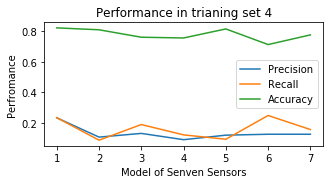

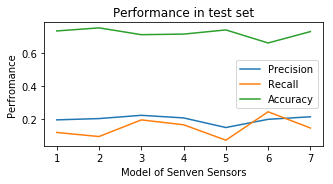

In [285]:
plt.figure(figsize=(5,5))
plt.subplot(2,1,1)
x_index=[1,2,3,4,5,6,7]
plt.plot(x_index,precision_list_train04_series,label = 'Precision')
plt.plot(x_index,recall_list_train04_series,label = 'Recall')
plt.plot(x_index,accuracy_list_train04_series,label = 'Accuracy')
plt.legend()
plt.title('Performance in trianing set 4')
plt.xlabel('Model of Senven Sensors')
plt.ylabel('Perfromance')
plt.show()
plt.figure(figsize=(5,5))
plt.subplot(2,1,2)
plt.plot(x_index,precision_list_test_set,label = 'Precision')
plt.plot(x_index,recall_list_test_set,label = 'Recall')
plt.plot(x_index,accuracy_list_test_set,label = 'Accuracy')
plt.legend()
plt.title('Performance in test set')
plt.xlabel('Model of Senven Sensors')
plt.ylabel('Perfromance')
plt.show()

C:\Users\zinaw\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


(410376, 411840)

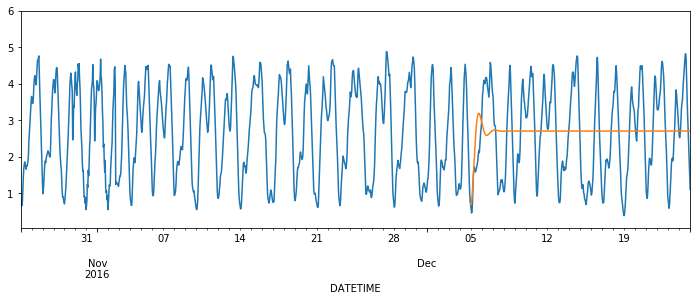

In [296]:
# for familiarization part
# predict  = arma_mod1.predict('2016-12-05', '2016-12-25', dynamic=True)
# # print(predict_sunspots)
# fig, ax = plt.subplots(figsize=(12, 4))
# ax = train04_series['L_T1'].ix['2016-07-04':].plot(ax=ax)
# predict.plot(ax=ax)
# plt.xlim('2016-10-25','2016-12-25')